In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/cis6800/VAE-GANs-CycleGANs

/content/drive/MyDrive/cis6800/VAE-GANs-CycleGANs


In [ ]:
# ! unzip -q test_case_VAE.zip
# ! unzip -q test_case_GAN.zip
# ! unzip -q cyclegan_files.zip

# VAE
### Load data for part 1.1 VAE


In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
import pdb

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='/content/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='/content/mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
# Check if a GPU is available, and if not, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Definition (TODO)

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, zdim):
    super(VAE,self).__init__()
    self.zdim = zdim

    self.encoder_1 = nn.Linear(784, 400)
    self.encoder_2_mean = nn.Linear(400, self.zdim)
    self.encoder_2_variance = nn.Linear(400, self.zdim)

    self.decoder_1 = nn.Linear(self.zdim, 400)
    self.decoder_2 = nn.Linear(400, 784)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def encode(self, X):
    output = self.relu(self.encoder_1(X))
    mean = self.relu(self.encoder_2_mean(output))
    log_var = self.relu(self.encoder_2_variance(output))
    return mean, log_var

  def decode(self, X):
    X = self.relu(self.decoder_1(X))
    X = self.decoder_2(X)
    X = self.sigmoid(X)
    return X

  def reparameterization(self, mean, log_var, eps=None):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std) if eps is None else eps
    z = mean + std * eps
    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var



# reparameterization's output is dynamic, for the test case, we use a fixed eps
# and all the intermediate result is provided.
# You could use these values to check if you get the final output z correct.
# Or you could add eps to the input when testing the reparameterization module.
# (warm reminder: don't forget to change back, cause the dynamic reparameterization is the key to VAE)

# TEST YOUR REPARAMETRIZATION FUNCTION with the values below
testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt')

model = VAE(5)
new_z = model.reparameterization(testcase_mean, testcase_log_var, testcase_eps)

# check the test cases
print(testcase_z, new_z)
print(testcase_z == new_z)

tensor([ 3.1778e+00, -1.0278e+01,  9.8815e-01,  6.0581e+00,  2.5477e+00,
        -6.4269e+00, -7.5505e-01,  1.1985e+00, -8.4017e-01,  5.4604e+00,
         5.2698e+00, -1.2687e+00, -1.8638e+00,  4.1139e+00, -2.3472e+00,
        -4.4407e+00,  1.9426e+00, -4.9737e+00, -5.9834e+00, -3.1362e+00,
        -3.2656e+00,  1.6548e+00,  2.2958e+01, -3.8683e-01, -4.3452e-01,
        -5.2965e+00, -4.5284e+01,  2.4358e-01,  5.7591e+00, -8.2570e+00,
         2.2764e+00,  8.9639e+00, -6.8475e+00,  2.1263e+01, -2.4059e+00,
         4.7735e-01,  6.9211e+00,  5.9699e+00, -1.8978e+00, -3.2031e+00,
        -7.3184e-01,  3.0327e+00, -2.3107e-01,  3.0637e+01,  4.2903e-01,
        -1.9582e+01, -2.6186e+00, -1.3860e+00,  2.2922e+00, -2.9969e+00,
         5.5873e+00,  1.4960e+01,  3.4692e+00, -4.5064e+00, -3.6529e-01,
        -4.5998e+00,  2.5015e+01,  2.8004e+00, -4.7923e+00, -1.5725e+00,
        -3.3229e+00,  1.3943e+00,  9.7628e-01, -4.5702e-01,  8.7089e-02,
        -1.1328e+01, -2.7700e-01, -3.8707e+00,  4.2

## VAE Train

### VAE Reconstruction Evaluation (TODO)
For this reconstruction evaluation module, you need to integrate into training procesure.

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms:
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE
    '''
    # set model to eval
    model.eval()
    # Initialize MSE Loss(use reduction='sum')
    mse = nn.MSELoss(reduction="sum") #tried with BCELoss too - subpar outputs.
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        idx_counter+=data.shape[0] # sum up the number of images in test_loader
        data = torch.flatten(data, start_dim=2).squeeze(1)
        x_reconstruction, mean, log_var = model.forward(data)
        recon_err += mse(data, x_reconstruction)
    avg_err = recon_err/idx_counter
    return avg_err

In [ ]:
reconstruction_error(model.to(device), test_loader)

tensor(135.4534, grad_fn=<DivBackward0>)

### Reconstruction error + KL divergence losses in VAE (TODO)

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    '''
    Compute reconstruction loss and KL divergence loss mentioned in pdf handout
    '''
    reconstruction_loss = torch.nn.BCELoss(reduction='sum')(recon_x, x)

    exp_log_var = torch.exp(log_var)
    mu_squared = torch.square(mu)
    KLD_term = exp_log_var + mu_squared - 1 - log_var
    KLD = 0.5 * torch.sum(KLD_term)

    totalloss = reconstruction_loss + KLD

    return totalloss, reconstruction_loss, KLD


#####################################################
# TEST CASE FOR VAE LOSS
#####################################################
testcase_loss_recon_x = torch.load('test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('test_case_VAE/loss_totalloss.pt')

loss, reconstruction_loss, KLD = loss_function(testcase_loss_recon_x, testcase_loss_x, testcase_loss_mu, testcase_loss_log_var)
print("test case loss value:", testcase_loss_totalloss.item())
print("computed loss value:", loss.item())

test case loss value: 1426.35888671875
computed loss value: 1426.35888671875


### VAE Training

In [ ]:
# Z dimension
ZDIM = 5

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs
num_epochs = 10
train_loss_list = []
orig_image_list = []
recon_image_list = []
reconst_error = []
reconst_error_epoch = []
KLD_epoch = []
reconst_loss_epoch = []

In [ ]:
# Define a function to log the output to a text file
def log_to_file(text):
    with open('training_log_vae.txt', 'a') as f:
        f.write(text + '\n')

In [ ]:
# Define Train loop
def train(epochs, train_loader, test_loader):
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        print('Epoch:', epoch+1,'LR:', scheduler.get_last_lr())
        log_to_file('Epoch: {} LR: {}'.format(epoch+1, scheduler.get_last_lr()))
        for batch_idx, (data, _) in enumerate(train_loader):
            # data = data.cuda() # remove comment when training on GPU!
            optimizer.zero_grad()

            data = torch.flatten(data, start_dim=2).squeeze(1)
            recon_batch, mean, log_var = vae(data)

            loss, reconstruction_loss, KLD = loss_function(recon_batch, data, mean, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                recon_err = reconstruction_error(vae, test_loader)
                reconst_error.append(recon_err) # epoch + step/batch wise
                print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {} \tKLD Loss: {} \tReconstruction Loss: {}'.format(
                    epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err, KLD.item() / len(data), reconstruction_loss.item() / len(data)))
                log_to_file('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {} \tKLD Loss: {} \tReconstruction Loss: {}'.format(
                    epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err, KLD.item() / len(data), reconstruction_loss.item() / len(data)))

            # save memory
            del recon_batch
            del mean
            del log_var

        train_loss_list.append(train_loss / len(train_loader.dataset))
        print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
        log_to_file('Epoch: {} Train loss: {:.4f}'.format(epoch + 1, train_loss / len(train_loader.dataset)))
        scheduler.step()

        recon_err = reconstruction_error(vae, test_loader)
        reconst_error_epoch.append(recon_err) # epoch wise
        KLD_epoch.append(KLD.item() / len(data))
        reconst_loss_epoch.append(reconstruction_loss.item()/ len(data))

        print('Epoch: {} Reconstruction Error: {:.4f} KLD Loss: {:.4f} Reconstruction Loss: {:.4f}'.format(epoch+1, recon_err, KLD / len(data), reconstruction_loss / len(data)))
        log_to_file('Epoch: {} Reconstruction Error: {:.4f} KLD Loss: {:.4f} Reconstruction Loss: {:.4f}'.format(epoch+1, recon_err, KLD / len(data), reconstruction_loss / len(data)))
        if epoch%5==0:
            with torch.no_grad():
                x_batch =torch.randn(10*10, ZDIM)
                recon_batch = vae.decode(x_batch.to(device))

            orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
            recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

        del data

    # save the training checkpoint
    checkpoint = {'vae': vae.state_dict()}
    torch.save(checkpoint, 'checkpoints/vae/vae_{}.pt'.format(epoch+1))

In [ ]:
# Run Train loop
train(num_epochs, train_loader, test_loader)

Epoch: 1 LR: [0.001]
Train Epoch: 1 0% 	Loss: 552.317344 	Recon_err: 128.26373291015625 	KLD Loss: 0.08208135604858398 	Reconstruction Loss: 552.2352734375
Train Epoch: 1 17% 	Loss: 292.417168 	Recon_err: 27.65776824951172 	KLD Loss: 10.93157958984375 	Reconstruction Loss: 281.4855859375
Train Epoch: 1 33% 	Loss: 265.013926 	Recon_err: 21.409439086914062 	KLD Loss: 11.33890869140625 	Reconstruction Loss: 253.67501953125
Train Epoch: 1 50% 	Loss: 265.890352 	Recon_err: 19.680540084838867 	KLD Loss: 11.39573486328125 	Reconstruction Loss: 254.494609375
Train Epoch: 1 67% 	Loss: 253.807910 	Recon_err: 18.885385513305664 	KLD Loss: 11.2028857421875 	Reconstruction Loss: 242.60501953125
Train Epoch: 1 83% 	Loss: 269.340664 	Recon_err: 18.405305862426758 	KLD Loss: 11.6850830078125 	Reconstruction Loss: 257.6555859375
Epoch: 1 Train loss: 273.2779
Epoch: 1 Reconstruction Error: 18.0733 KLD Loss: 11.2413 Reconstruction Loss: 238.6551
Epoch: 2 LR: [0.001]
Train Epoch: 2 0% 	Loss: 254.950254 	R

In [ ]:
np.save("checkpoints/vae/reconstruction_error.npy", torch.tensor(reconst_error))
np.save("checkpoints/vae/reconstruction_error_epoch.npy", torch.tensor(reconst_error_epoch))
np.save("checkpoints/vae/KL_divergence_loss_epoch.npy", torch.tensor(KLD_epoch))
np.save("checkpoints/vae/reconstruction_loss_epoch.npy", torch.tensor(reconst_loss_epoch))
np.save("checkpoints/vae/training_loss.npy", train_loss_list)

In [ ]:
def plot_loss_curve(loss_data, title, ylabel, filename=None):
    # Start the x-axis at epoch 1 and have intervals of 1
    x = np.arange(1, len(loss_data) + 1)

    plt.title(title)
    plt.plot(x, loss_data, label=ylabel)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, len(loss_data) + 1, step=1))
    plt.legend()

    if filename:
        plt.savefig(filename)  # Save the plot to a file if a filename is provided
    else:
        plt.show()

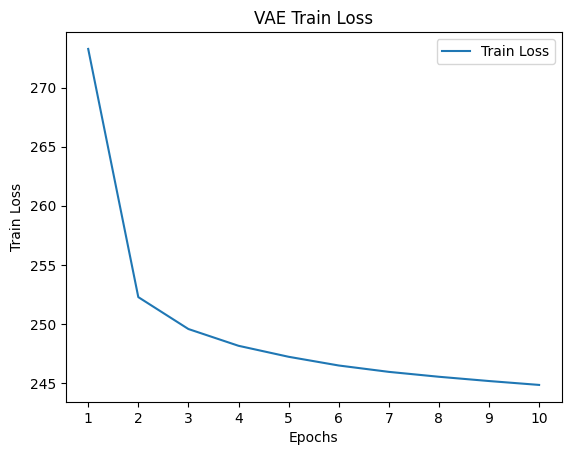

In [ ]:
# Plot Train loss
train_loss_list = np.load("checkpoints/vae/training_loss.npy")
plot_loss_curve(train_loss_list, "VAE Train Loss", "Train Loss")

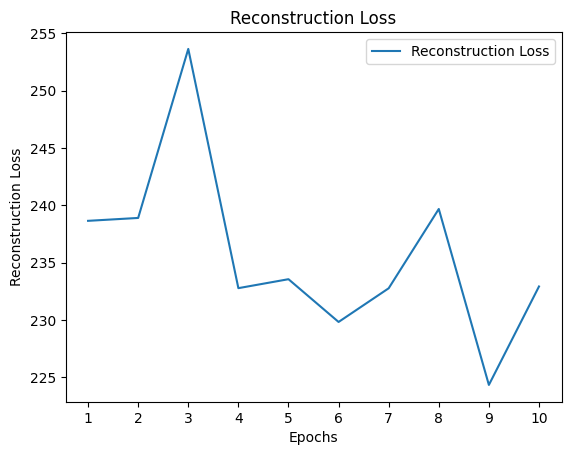

In [ ]:
# Plot Reconstruction loss
reconstruction_loss_epoch = np.load("checkpoints/vae/reconstruction_loss_epoch.npy")
plot_loss_curve(reconstruction_loss_epoch, "Reconstruction Loss", "Reconstruction Loss")

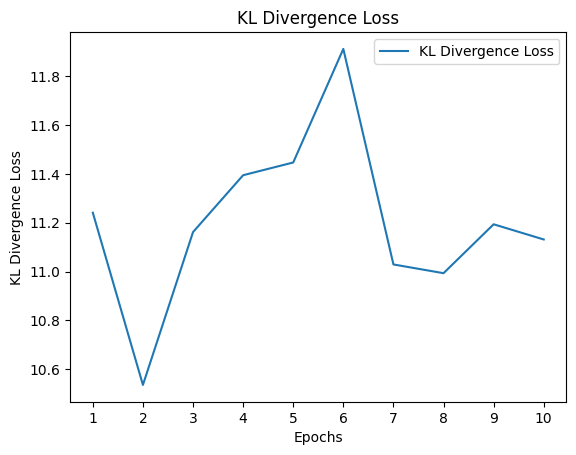

In [ ]:
# Plot KL Divergence loss
kl_divergence_loss_epoch = np.load("checkpoints/vae/KL_divergence_loss_epoch.npy")
plot_loss_curve(kl_divergence_loss_epoch, "KL Divergence Loss", "KL Divergence Loss")

## Qualitative Visualisations

### VAE Testing

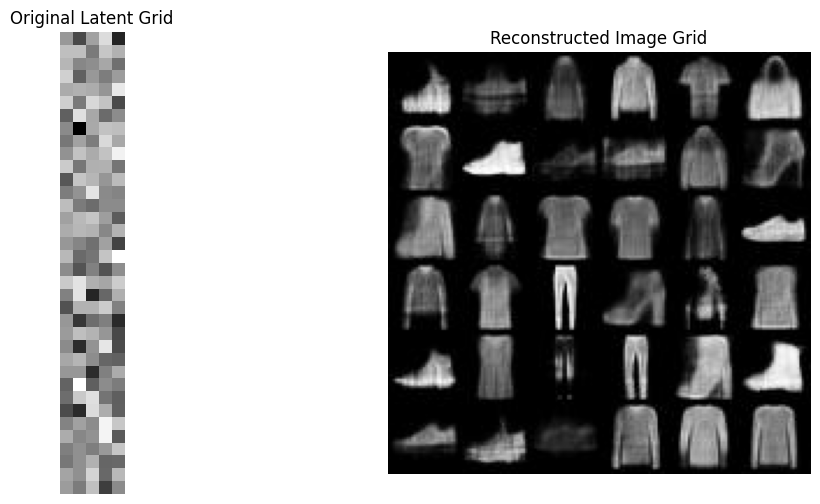

In [ ]:
grid_size = 6
latent_dim = 5

# Generate random latent vectors
latent_samples = torch.randn(grid_size * grid_size, latent_dim)

# Create a grid of original latent vectors
original_latent_grid = vutils.make_grid(latent_samples, nrow=grid_size, padding=2, normalize=True)


reconstructed_samples = vae.decode(latent_samples.to(device))
reconstructed_image_grid = vutils.make_grid(reconstructed_samples.view(-1, 1, 28, 28).detach().cpu(), nrow=grid_size, padding=2, normalize=True)

# Save the grids as images
save_image(original_latent_grid, "vae_save_files/original_latent_grid.jpg")
save_image(reconstructed_image_grid, "vae_save_files/reconstructed_image_grid.jpg")

# Load the saved images
original_latent_image = mpimg.imread("vae_save_files/original_latent_grid.jpg")
reconstructed_image = mpimg.imread("vae_save_files/reconstructed_image_grid.jpg")

# Create subplots for displaying the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set titles and display the images
titles = ["Original Latent Grid", "Reconstructed Image Grid"]
images = [original_latent_image, reconstructed_image]

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.imshow(images[i])
    ax.axis('off')

plt.show()

### Visualize the original vs reconstructed images (TODO)

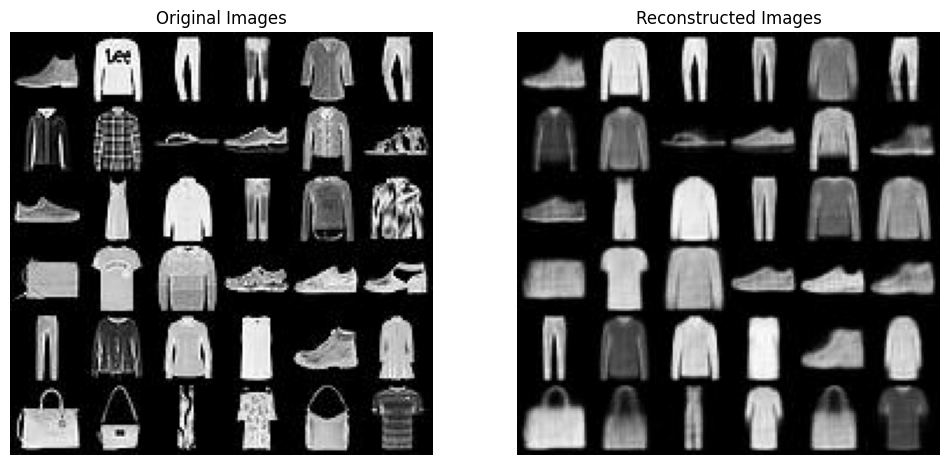

In [ ]:
vae.eval()
# Initialize Mean Squared Error (MSE) Loss (use reduction='sum')
mse_loss = nn.MSELoss(reduction="sum")

for batch_idx, (test_data, _) in enumerate(test_loader):
    test_data = test_data.to(device)

    # Feed forward data to VAE
    test_data = torch.flatten(test_data, start_dim=2).squeeze(1)
    reconstructed_data, mean, log_var = vae.forward(test_data)

    original_img_grid = vutils.make_grid(test_data[0:36, :].view(36, 1, 28, 28), nrow=6, padding=2, normalize=True)
    reconstructed_img_grid = vutils.make_grid(reconstructed_data[0:36, :].view(36, 1, 28, 28).detach().cpu(), nrow=6, padding=2, normalize=True)

    save_image(original_img_grid, "vae_save_files/epoch_full_original.jpg")
    save_image(reconstructed_img_grid, "vae_save_files/epoch_full_reconstructed.jpg")

    # Display the original and reconstructed image grids
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, title in enumerate(["Original Images", "Reconstructed Images"]):
        image = mpimg.imread(f"vae_save_files/epoch_full_{'original' if i == 0 else 'reconstructed'}.jpg")
        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

    break

## Quantitative Evaluation (TODO)

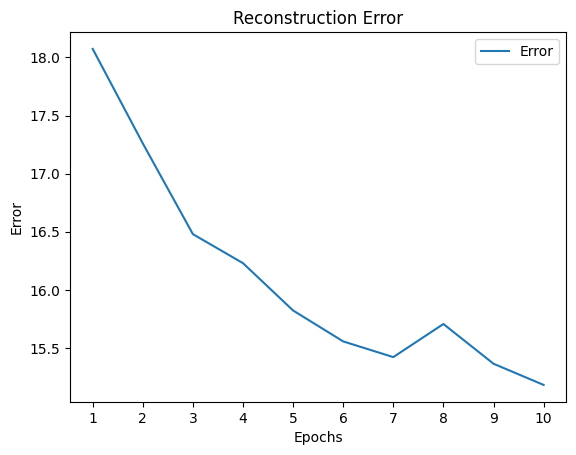


Final Reconstruction Error Value:  15.1814785


In [ ]:
# Please plot out the reconstruction error curve you saved
# in 'reconstruction_error' list in training.
# And report the final reconstruction error value
# Plot Reconstruction Error curve
recon_err_epoch = np.load("checkpoints/vae/reconstruction_error_epoch.npy")
plot_loss_curve(recon_err_epoch, "Reconstruction Error", "Error")

print("\nFinal Reconstruction Error Value: ", recon_err_epoch[-1])

### VAE IS score

The following block create 2 torch dataset.

Restart Colab to refresh RAM. We load the model from checkpoint.

In [ ]:
num_epochs = 10
ZDIM = 5

model_saved = torch.load('checkpoints/vae/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM)
model_vae.load_state_dict(model_saved['vae'])

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='/content/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0]
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)

    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)


    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))

#### Self-implement IS score (optional TODO)
This optional part is for implementing IS score computation following pdf instructions. You could also use the the next section "IS API" to compute the IS score.
For implementation, you would be asked to implement the most important part "compute_IS" function as an understanding of IS score computation.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            else:
                pred = image
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
        del image
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    # Split the feature table into two parts: p(y|x) and p(y)
    p_yx = feature_table  # p(y|x) is the feature table itself
    p_y = np.mean(p_yx, axis=0)  # p(y) is the marginal class distribution

    # Calculate the KL divergence for each image and class
    kl_divergences = p_yx * (np.log(p_yx) - np.log(p_y))
    # Sum the KL divergences for each image
    kl_divergence_per_image = np.sum(kl_divergences, axis=1)

    # Calculate the Inception Score
    IS_score = np.exp(np.mean(kl_divergence_per_image))

    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1', transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_set, device, upsample = True)
gen_set_IS_score = IS(gen_set, device, upsample = True)

print('\n\nreal images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 30.1MB/s]
16it [07:13, 27.10s/it]
16it [07:09, 26.85s/it]



real images IS_score: 4.172445662744481
generated images IS_score: 2.792313918591754


#### IS API
Here you could apply the existed API to compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=False, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=False, batch_size=64, resize=True, splits=1))

real images IS_score:
(4.172445699083032, 0.0)
generated images IS_score:
(2.7923139149691045, 0.0)


# GAN (please restart you colab session to refresh the GPU memory usage)
### Load data for part 2.1 GAN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
import pdb

# Check if a GPU is available, and if not, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='/content/stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 2640397119/2640397119 [09:11<00:00, 4788376.46it/s]


Extracting /content/stl10_data/stl10_binary.tar.gz to /content/stl10_data/


## Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=100,
                out_channels=1024,
                kernel_size=(4, 4),
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=1024,
                out_channels=512,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=3,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layer(x)

class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=128,
                kernel_size=(4, 4),
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=512,
                out_channels=1024,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=1024,
                out_channels=1,
                kernel_size=(4, 4),
                stride=1,
                padding=0
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)

## GAN Training

### GAN loss

In [ ]:
fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):
    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    # Forward real images into the discriminator
    real_output = D(real).squeeze()

    loss_real = criterion(real_output, Valid_label)

    # Forward noise into the generator to generate fake images
    fake_images = G(noise)

    # Forward fake images to the discriminator
    fake_output = D(fake_images).squeeze()

    loss_fake = criterion(fake_output, Fake_label)

    loss_D = loss_real + loss_fake

    return loss_D, fake_images

def loss_generator(netD, fake, Valid_label, criterion):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    fake_images_D = netD(fake).squeeze()

    generator_loss = criterion(fake_images_D, Valid_label)

    return generator_loss

loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
torch.save(loss_G, 'test_case_GAN/loss_G.pt')

test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())

test case loss_D: 1.3626351356506348
computed loss_D: 1.3626351356506348
test case loss_G: 0.7321602702140808
computed loss_G: 0.7321602702140808


### Training block

In [ ]:
# Define a function to log the output to a text file
def log_to_file(text):
    with open('training_log_gans.txt', 'a') as f:
        f.write(text + '\n')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
G_losses_epoch = []
D_losses_epoch = []
iters = 0
num_epochs = 100


def load_param(num_eps):
    model_saved = torch.load('checkpoints/gans/gan_{}.pt'.format(num_eps))
    netG.load_state_dict(model_saved['netG'])
    netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    total = 0
    g_epoch_loss = 0
    d_epoch_loss = 0
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        total += b_size
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Function to compute discriminator loss
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)


        # torch.save(fake,'test_case_GAN/fake.pt')
        # torch.save(netD,'test_case_GAN/netD.pt')
        # torch.save(real,'test_case_GAN/real.pt')
        # torch.save(netG,'test_case_GAN/netG.pt')
        # torch.save(noise,'test_case_GAN/noise.pt')
        # torch.save(Valid_label,'test_case_GAN/Valid_label.pt')
        # torch.save(Fake_label,'test_case_GAN/Fake_label.pt')
        # torch.save(criterion,'test_case_GAN/criterion.pt')

        # pdb.set_trace()

        loss_D.backward(retain_graph=True)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Function to compute generator loss
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
        # Calculate gradients for G
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))
            log_to_file('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        g_epoch_loss += loss_G.item()
        d_epoch_loss += loss_D.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    if((epoch+1) % 10==0):
        print("Saving at epoch ", epoch+1)
        checkpoint = {'netG': netG.state_dict(),
                    'netD': netD.state_dict()}
        torch.save(checkpoint, 'checkpoints/gans/gan_{}.pt'.format(epoch+1))
    g_avg_loss = g_epoch_loss  / total
    d_avg_loss = d_epoch_loss  / total
    G_losses_epoch.append(g_avg_loss)
    D_losses_epoch.append(d_avg_loss)

checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'checkpoints/gans/gan_{}.pt'.format(num_epochs))

[1/100][0/40]	Loss_D: 1.3595	Loss_G: 1.0032	
[2/100][0/40]	Loss_D: 0.0422	Loss_G: 4.1058	
[3/100][0/40]	Loss_D: 0.0151	Loss_G: 5.1186	
[4/100][0/40]	Loss_D: 0.5365	Loss_G: 2.1683	
[5/100][0/40]	Loss_D: 0.3404	Loss_G: 3.0435	
[6/100][0/40]	Loss_D: 2.3892	Loss_G: 1.7135	
[7/100][0/40]	Loss_D: 0.5291	Loss_G: 2.4607	
[8/100][0/40]	Loss_D: 1.2187	Loss_G: 1.2889	
[9/100][0/40]	Loss_D: 1.4869	Loss_G: 3.5147	
[10/100][0/40]	Loss_D: 0.4442	Loss_G: 2.4729	
Saving at epoch  10
[11/100][0/40]	Loss_D: 0.5557	Loss_G: 3.4332	
[12/100][0/40]	Loss_D: 0.9829	Loss_G: 3.4591	
[13/100][0/40]	Loss_D: 0.4099	Loss_G: 3.3692	
[14/100][0/40]	Loss_D: 2.4227	Loss_G: 3.9264	
[15/100][0/40]	Loss_D: 1.1796	Loss_G: 3.4753	
[16/100][0/40]	Loss_D: 0.8909	Loss_G: 2.2832	
[17/100][0/40]	Loss_D: 0.4539	Loss_G: 3.0583	
[18/100][0/40]	Loss_D: 1.1152	Loss_G: 3.5460	
[19/100][0/40]	Loss_D: 0.9875	Loss_G: 4.2876	
[20/100][0/40]	Loss_D: 1.1059	Loss_G: 4.5185	
Saving at epoch  20
[21/100][0/40]	Loss_D: 0.6750	Loss_G: 2.3411	
[22

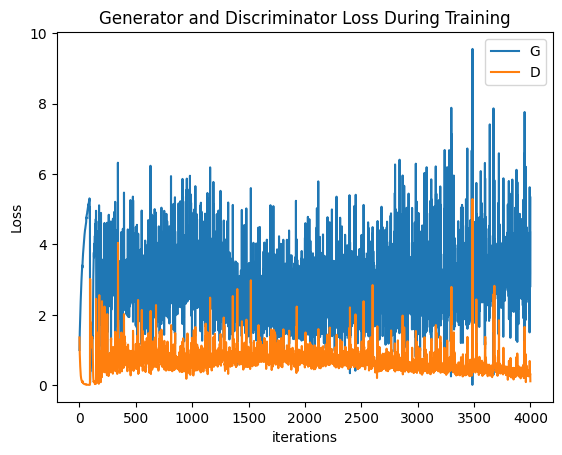

In [ ]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

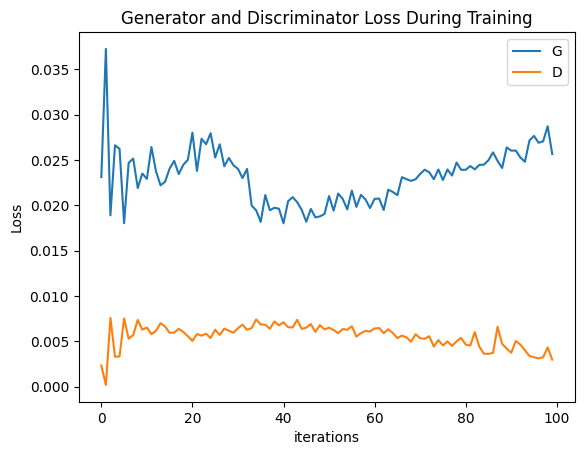

In [ ]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_epoch,label="G")
plt.plot(D_losses_epoch,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### GAN Testing after training

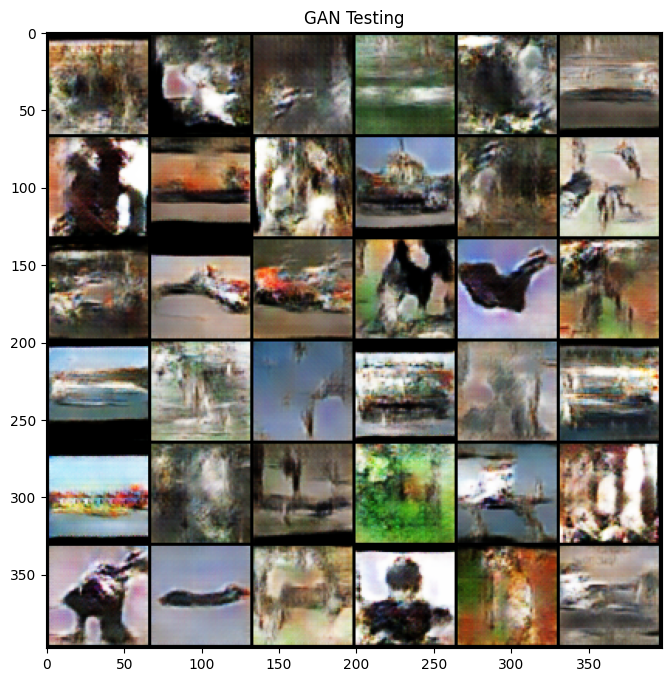

In [ ]:
ep = 100
nz = 100
b_size = 36
latentVar = torch.randn(b_size, nz, 1, 1, device=device)
netD = DCGAN_Discriminator().to(device)
netG = DCGAN_Generator().to(device)

def load_param(num_eps):
    model_saved = torch.load('checkpoints/gans/gan_{}.pt'.format(num_eps))
    netG.load_state_dict(model_saved['netG'])
    netD.load_state_dict(model_saved['netD'])

def oneModelTest(ep):
    load_param(ep)
    with torch.no_grad():
        image_6x6 = netG(latentVar)
        images_in_grid = vutils.make_grid(image_6x6, nrow=6 , normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(images_in_grid.cpu().numpy().transpose(1,2,0))
        plt.title("GAN Testing")
        plt.show()

oneModelTest(ep)

### Visualisation at different epochs

In [ ]:
# Plot GAN generated images at different epochs during training
for i in np.arange(10,100,10):
    print("Epoch: ",i)
    oneModelTest(i)

Output hidden; open in https://colab.research.google.com to view.

## Quantitative Evaluation

In [ ]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='/content/stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN
This part, you would be asked to compute a FID score between the real image and the generated images to evaluate the photo-realistic quality of the generated images.
For this part, we should create three folder:
- 1. STL_10_real_1
- 2. STL_10_real_2
- 3. STL_10_fake


In [ ]:
! mkdir 'gan_save_files' 'gan_save_files/STL_10_fake' 'gan_save_files/STL_10_real_1' 'gan_save_files/STL_10_real_2'

Create the dataset to evaluate quantitative scores.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
num_epochs = 100
# Load checkpoint
model_saved = torch.load('checkpoints/gans/gan_{}.pt'.format(num_epochs))
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y

evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)

        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), 'gan_save_files/STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), 'gan_save_files/STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), 'gan_save_files/STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))

#### Self-implement FID score (optional TODO)
This optional part is for implementing FID score computation following pdf instructions. Implement "compute_FID" function which is the most important part in FID score computation. You could also use the the next section "FID API" to compute the FID score.

In [ ]:
import numpy as np
from scipy import linalg
import torch
from torchvision.models import inception_v3
from torchvision import transforms
import tqdm
! pip install pytorch-fid &> /dev/null
from pytorch_fid.inception import InceptionV3

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)

        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)

    return feature_table

def compute_stat(feature_table):
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)
    return mu, sigma

def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    offset = np.eye(sigma_1.shape[0]) * eps
    covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    diff = mu_1 - mu_2
    fid = np.sum(diff**2) + np.trace(sigma_1) + np.trace(sigma_2) - 2 * np.trace(covmean)
    return fid

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx=3):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)

    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)

    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)

    return FID_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute FID using FID function you implemented above
FID_score = FID(real_dataset_1, real_dataset_1, device)
print('FID_score between real_dataset_1 and itself:', FID_score)

FID_score = FID(real_dataset_1, real_dataset_2, device)
print('FID_score between real_dataset_1 and real_dataset_2:', FID_score)

FID_score = FID(real_dataset_1, gen_dataset, device)
print('FID_score between real_dataset_1 and generated image set:', FID_score)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 208MB/s]
16it [00:03,  4.43it/s]
16it [00:03,  4.50it/s]


FID_score between real_dataset_1 and itself: -0.004096001161713048


16it [00:03,  4.49it/s]
16it [00:03,  4.47it/s]


FID_score between real_dataset_1 and real_dataset_2: 37.65076163961851


16it [00:03,  4.59it/s]
16it [00:03,  4.59it/s]


FID_score between real_dataset_1 and generated image set: 205.9856779376879


#### FID API

In [ ]:
! pip install pytorch-fid &> /dev/null
! pip install scipy==1.11.1 &> /dev/null
! python -m pytorch_fid 'gan_save_files/STL_10_real_1' 'gan_save_files/STL_10_real_1'
! python -m pytorch_fid 'gan_save_files/STL_10_real_1' 'gan_save_files/STL_10_real_2'
! python -m pytorch_fid 'gan_save_files/STL_10_real_1' 'gan_save_files/STL_10_fake'

100% 20/20 [00:04<00:00,  4.40it/s]
100% 20/20 [00:03<00:00,  5.16it/s]
FID:  -2.1626007026043226e-05
100% 20/20 [00:04<00:00,  4.42it/s]
100% 20/20 [00:03<00:00,  5.16it/s]
FID:  37.67576040619059
100% 20/20 [00:04<00:00,  4.74it/s]
100% 20/20 [00:03<00:00,  5.18it/s]
FID:  206.12756999394225


If you implement the self-implement FID version. You would notice a negligible difference in value. Because the API package compute this value by saving and reading tensor from .png files. Accuracy problem could happen in the middle of transation.

### IS score for GAN

#### Self-implement IS score (optional)

You could copy and paste this function from VAE part if you have implement that part.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    # Split the feature table into two parts: p(y|x) and p(y)
    p_yx = feature_table  # p(y|x) is the feature table itself
    p_y = np.mean(p_yx, axis=0)  # p(y) is the marginal class distribution

    # Calculate the KL divergence for each image and class
    kl_divergences = p_yx * (np.log(p_yx) - np.log(p_y))
    # Sum the KL divergences for each image
    kl_divergence_per_image = np.sum(kl_divergences, axis=1)

    # Calculate the Inception Score
    IS_score = np.exp(np.mean(kl_divergence_per_image))

    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_dataset_1, device, upsample = True)
gen_set_IS_score = IS(gen_dataset, device, upsample = True)
print('\n\nreal images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 35.9MB/s]
16it [00:03,  4.43it/s]
16it [00:03,  4.49it/s]




real images IS_score: 14.623364177178383
generated images IS_score: 2.294612312151362


#### IS API

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:
(14.623364188788035, 0.0)
IS score for generated data set:
(2.2946123116089803, 0.0)
